In [174]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [175]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=1000')

df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [176]:
df.drop(["conversionType", "conversionSymbol", "high", "low", "volumeto"], axis = 'columns', inplace = True)
df.head(20)

,open,volumefrom,close
time,,,
2020-10-13,0.10950,20433258.44,0.10940
2020-10-14,0.10940,14040545.93,0.10730
2020-10-15,0.10730,14517725.18,0.10670
2020-10-16,0.10670,14150634.42,0.10430
2020-10-17,0.10430,7993435.23,0.10610
2020-10-18,0.10610,4905747.42,0.10750
2020-10-19,0.10750,11367287.09,0.10870
2020-10-20,0.10870,20036522.11,0.10240
2020-10-21,0.10240,22322860.33,0.10620


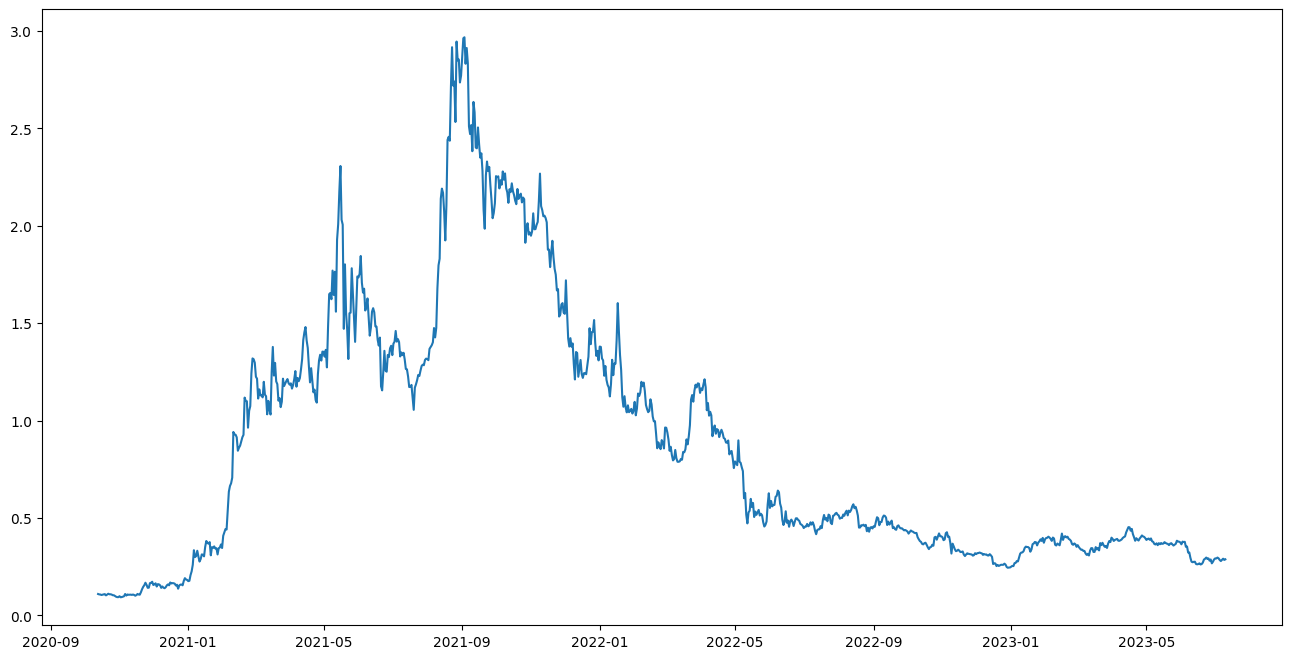

In [177]:
plt.figure(figsize=(16,8))
plt.plot(df[target_col],label='Close Price history')

In [178]:
def train_test_split(df, test_size=0.2) -> pd.DataFrame:
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [179]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

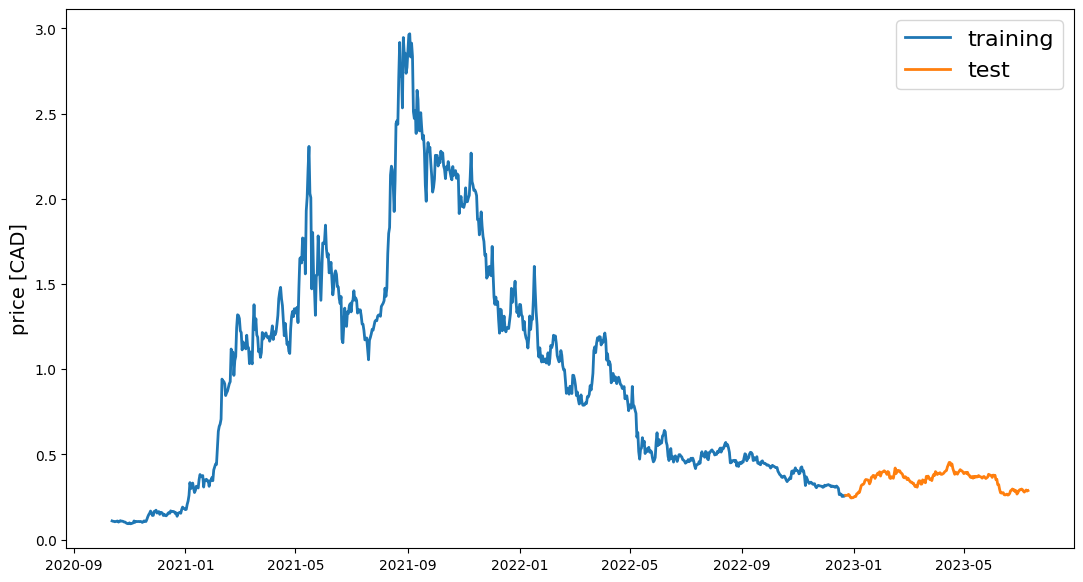

In [180]:
train, test = train_test_split(df)
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [181]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [182]:
np.random.seed(42)
window_len = 10
test_size = 0.2
zero_base = True
lstm_neurons = 200
epochs = 30
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [183]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [184]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/30
25/25 [==============================] - 3s 36ms/step - loss: 0.0287 - val_loss: 0.0050
Epoch 2/30
25/25 [==============================] - 0s 20ms/step - loss: 0.0136 - val_loss: 0.0033
Epoch 3/30
25/25 [==============================] - 1s 23ms/step - loss: 0.0126 - val_loss: 0.0037
Epoch 4/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0107 - val_loss: 0.0026
Epoch 5/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0097 - val_loss: 0.0032
Epoch 6/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0093 - val_loss: 0.0021
Epoch 7/30
25/25 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0027
Epoch 8/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0091 - val_loss: 0.0025
Epoch 9/30
25/25 [==============================] - 1s 21ms/step - loss: 0.0087 - val_loss: 0.0019
Epoch 10/30
25/25 [==============================] - 0s 18ms/step - loss: 0.0080 - val_loss: 0.0019
Epoch 11/

{'loss': [0.028748314827680588, 0.013607724569737911, 0.012569504790008068, 0.010670555755496025, 0.009686343371868134, 0.009272431023418903, 0.00932135246694088, 0.009122909046709538, 0.008697216399013996, 0.008002318441867828, 0.0077255116775631905, 0.0074335434474051, 0.007367487531155348, 0.006865083705633879, 0.007711755111813545, 0.007465758826583624, 0.007240139413625002, 0.006592842750251293, 0.006819605827331543, 0.006891694385558367, 0.006645884830504656, 0.0062688617035746574, 0.0060840025544166565, 0.005854868795722723, 0.006012581288814545, 0.005746783688664436, 0.005933315958827734, 0.0059411777183413506, 0.005872179288417101, 0.006029581185430288], 'val_loss': [0.004964627791196108, 0.003318023169413209, 0.0037248742301017046, 0.0025922933127731085, 0.003192565403878689, 0.0020889954175800085, 0.0027363235130906105, 0.002487796125933528, 0.0019234337378293276, 0.0019218726083636284, 0.0019906060770154, 0.0019970727153122425, 0.0018352917395532131, 0.0019737279508262873, 

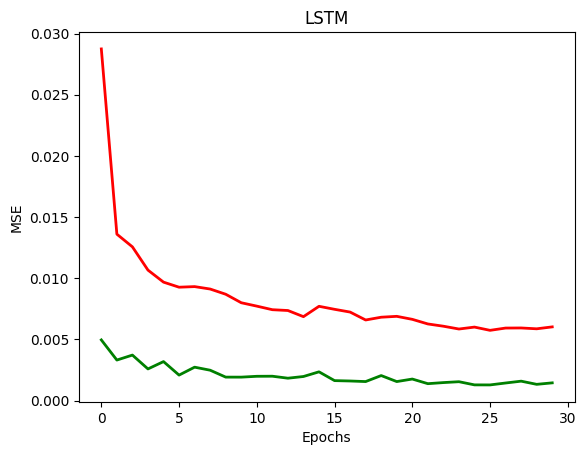

In [185]:
import matplotlib.pyplot as plt
print(history.history)
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [186]:
from sklearn.metrics import mean_absolute_error


targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

6/6 [==============================] - 0s 7ms/step


0.028970283339256997

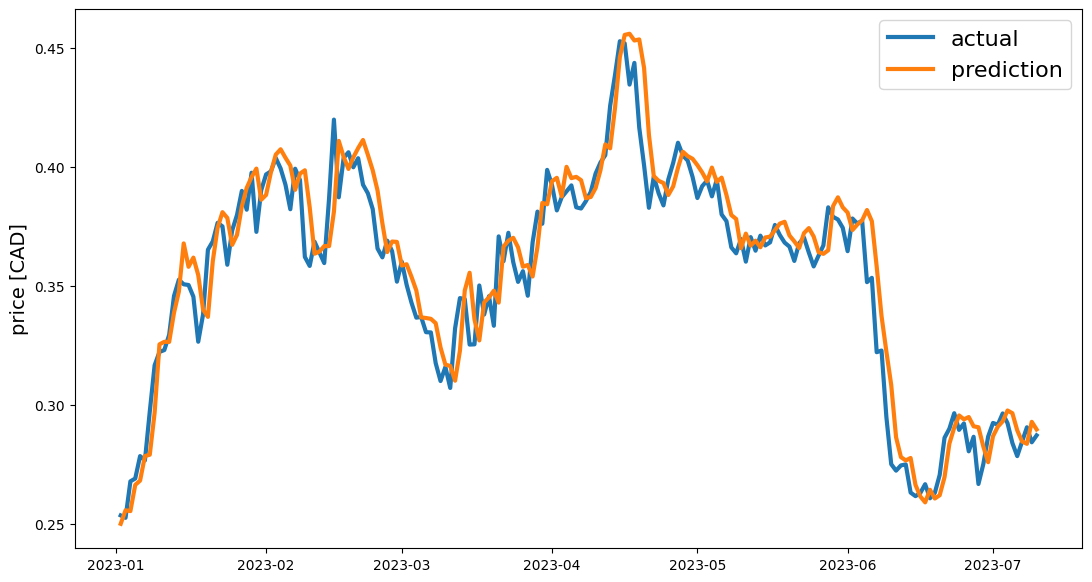

In [187]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [188]:
model.save("crypto_ada_model.h5")

c:\Users\nvtph\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
